In [1]:
import sys
sys.path.append('dataset')
import data_handler
import numpy as np
import napari
from PIL import Image
from environment import Variables
from itertools import product

In [2]:
dataMachine = data_handler.DataHandler()

In [3]:
img, label = dataMachine.augmentEpoch(30)

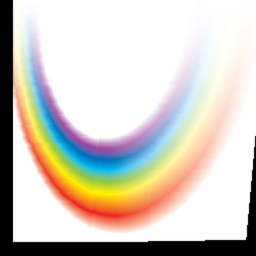

In [4]:
new  = Image.fromarray(np.uint8(img[4])).convert('RGB')
new

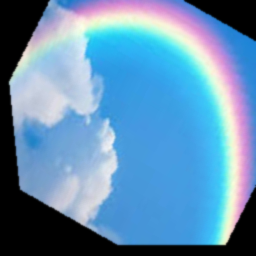

In [5]:
new  = Image.fromarray(np.uint8(img[5])).convert('RGB')
new

In [6]:
np.shape(label[15])

(21, 64, 64)

In [7]:
np.min(label[4])

0.0

In [264]:
viewer = napari.Viewer()
viewer.add_image(label[4], name='rwerewr')
napari.run()

In [265]:
viewer = napari.Viewer()
viewer.add_image(label[12], name='rwerewr')
napari.run()

In [8]:
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.losses import mean_squared_error
import keras.backend as K


def create_hourglass_network(num_classes, num_stacks, num_channels, inres, outres, bottleneck):
    input = Input(shape=(inres[0], inres[1], 3))

    front_features = create_front_module(input, num_channels, bottleneck)

    head_next_stage = front_features

    outputs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, bottleneck, i)
        outputs.append(head_to_loss)

    model = Model(inputs=input, outputs=outputs)
    rms = RMSprop(learning_rate=5e-4)
    model.compile(optimizer=rms, loss=mean_squared_error, metrics=["accuracy"])

    return model


def hourglass_module(bottom, num_classes, num_channels, bottleneck, hgid):
    # create left features , f1, f2, f4, and f8
    left_features = create_left_half_blocks(bottom, bottleneck, hgid, num_channels)

    # create right features, connect with left features
    rf1 = create_right_half_blocks(left_features, bottleneck, hgid, num_channels)

    # add 1x1 conv with two heads, head_next_stage is sent to next stage
    # head_parts is used for intermediate supervision
    head_next_stage, head_parts = create_heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = Conv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def bottleneck_mobile(bottom, num_out_channels, block_name):
    # skip layer
    if K.int_shape(bottom)[-1] == num_out_channels:
        _skip = bottom
    else:
        _skip = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                                name=block_name + 'skip')(bottom)

    # residual: 3 conv blocks,  [num_out_channels/2  -> num_out_channels/2 -> num_out_channels]
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x1')(bottom)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels / 2, kernel_size=(3, 3), activation='relu', padding='same',
                         name=block_name + '_conv_3x3_x2')(_x)
    _x = BatchNormalization()(_x)
    _x = SeparableConv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                         name=block_name + '_conv_1x1_x3')(_x)
    _x = BatchNormalization()(_x)
    _x = Add(name=block_name + '_residual')([_skip, _x])

    return _x


def create_front_module(input, num_channels, bottleneck):
    # front module, input to 1/4 resolution
    # 1 7x7 conv + maxpooling
    # 3 residual block

    _x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    _x = BatchNormalization()(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(_x)

    _x = bottleneck(_x, num_channels // 2, 'front_residual_x2')
    _x = bottleneck(_x, num_channels, 'front_residual_x3')

    return _x


def create_left_half_blocks(bottom, bottleneck, hglayer, num_channels):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8 : 1, 1/2, 1/4 1/8 resolution

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck(bottom, num_channels, hgname + '_l1')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck(_x, num_channels, hgname + '_l2')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck(_x, num_channels, hgname + '_l4')
    _x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck(_x, num_channels, hgname + '_l8')

    return (f1, f2, f4, f8)


def connect_left_to_right(left, right, bottleneck, name, num_channels):
    '''
    :param left: connect left feature to right feature
    :param name: layer name
    :return:
    '''
    # left -> 1 bottlenect
    # right -> upsampling
    # Add   -> left + right

    _xleft = bottleneck(left, num_channels, name + '_connect')
    _xright = UpSampling2D()(right)
    add = Add()([_xleft, _xright])
    out = bottleneck(add, num_channels, name + '_connect_conv')
    return out


def bottom_layer(lf8, bottleneck, hgid, num_channels):
    # blocks in lowest resolution
    # 3 bottlenect blocks + Add

    lf8_connect = bottleneck(lf8, num_channels, str(hgid) + "_lf8")

    _x = bottleneck(lf8, num_channels, str(hgid) + "_lf8_x1")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x2")
    _x = bottleneck(_x, num_channels, str(hgid) + "_lf8_x3")

    rf8 = Add()([_x, lf8_connect])

    return rf8


def create_right_half_blocks(leftfeatures, bottleneck, hglayer, num_channels):
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, bottleneck, hglayer, num_channels)

    rf4 = connect_left_to_right(lf4, rf8, bottleneck, 'hg' + str(hglayer) + '_rf4', num_channels)

    rf2 = connect_left_to_right(lf2, rf4, bottleneck, 'hg' + str(hglayer) + '_rf2', num_channels)

    rf1 = connect_left_to_right(lf1, rf2, bottleneck, 'hg' + str(hglayer) + '_rf1', num_channels)

    return rf1


def create_heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    # two head, one head to next stage, one head to intermediate features
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + '_conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    # for head as intermediate supervision, use 'linear' as activation.
    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + '_conv_1x1_parts')(head)

    # use linear activation
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + '_conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + '_conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts


def euclidean_loss(x, y):
    return K.sqrt(K.sum(K.square(x - y)))

2024-08-15 19:47:02.492823: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from bipartiteLoss import bipartite_loss

In [10]:
import tensorflow as tf
from scipy.optimize import linear_sum_assignment

# Define the Hungarian algorithm to use scipy
def hungarian_algorithm(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return row_ind.astype(np.int32), col_ind.astype(np.int32)

# Define the bipartite loss function
def bipartite_loss(y_pred, y_true):
    if Variables.LOSS == "Map matching":
        cost_matrix = tf.map_fn(
            lambda i: tf.map_fn(
                lambda j: tf.reduce_sum(tf.square(y_pred[i] - y_true[j])),
                tf.range(y_true.shape[0]),
                dtype=tf.float32
            ),
        tf.range(y_pred.shape[0]),
        dtype=tf.float32
        )
    # elif Variables.LOSS = "Point":
        
    
    # # Find the optimal matching using the Hungarian algorithm
    row_ind, col_ind = tf.py_function(hungarian_algorithm, [cost_matrix], [tf.int64, tf.int64])
    indices = tf.stack([row_ind, col_ind], axis=1)

    # Calculate the total sum of the matched pairs
    total_sum = tf.reduce_mean(tf.gather_nd(cost_matrix, indices))

    return total_sum

@tf.function
def loss_func(y_pred, y_true):
    # Apply bipartite loss function across all elements in the batch
    loss_per_example = tf.map_fn(
        lambda p_t: bipartite_loss(tf.transpose(p_t[0], perm=[1, 2, 0]), p_t[1]),
        (y_pred, y_true),
    dtype=tf.float32)
    
    print(tf.reduce_mean(loss_per_example))
    return tf.reduce_mean(loss_per_example)

In [11]:
label[4]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [12]:
import tensorflow as tf

# Create a tensor that goes from 0 to 256 from left to right (shape: 64, 64)
left_to_right = tf.tile(tf.linspace(-1.0, 1.0, 64)[tf.newaxis, :], [64, 1])

# Create a tensor that goes from 0 to 256 from top to bottom (shape: 64, 64)
top_to_bottom = tf.tile(tf.linspace(-1.0, 1.0, 64)[:, tf.newaxis], [1, 64])

In [231]:
product = label[4] * left_to_right 
result1 = tf.reduce_sum(product, axis=[1, 2])

In [232]:
np.max(product[0])

0.33333337

In [233]:
product = label[4] * top_to_bottom 
result2 = tf.reduce_sum(product, axis=[1, 2])

In [234]:
result1

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([  8.360432  ,   5.1755056 ,  -1.9905771 , -10.749125  ,
       -17.118977  , -21.698357  , -14.4251    , -20.303902  ,
         0.39811718,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ], dtype=float32)>

In [225]:
result2

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([ 9.952893, 13.535935, 18.313324, 19.109554, 16.322744, 11.106466,
        4.059683, 13.535935, 16.72086 ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ], dtype=float32)>

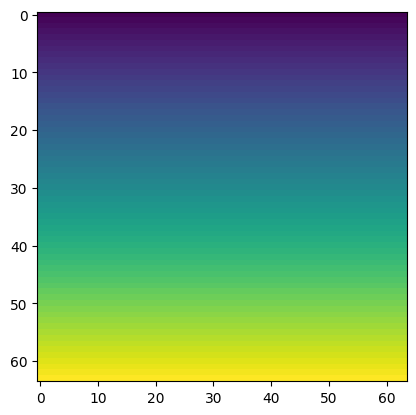

In [203]:
import matplotlib.pyplot as plt
plt.imshow(top_to_bottom)

In [206]:
top_to_bottom[62]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652, 251.93652, 251.93652,
       251.93652, 251.93652, 251.93652, 251.93652], dtype=float32)>

In [202]:
plt.show()

In [54]:
print(gah)

tf.Tensor(9.723602705961875, shape=(), dtype=float64)


In [13]:
gah = loss_func(tf.expand_dims(tf.constant(label[4]), axis=0),tf.expand_dims(tf.constant(label[5]), axis=0))


Instructions for updating:
Use fn_output_signature instead


ValueError: in user code:

    File "/var/folders/dh/q82pryy531b44v7c44hsdrvw0000gn/T/ipykernel_16544/1280153510.py", line 36, in loss_func  *
        loss_per_example = tf.map_fn(
    File "/var/folders/dh/q82pryy531b44v7c44hsdrvw0000gn/T/ipykernel_16544/1280153510.py", line 12, in bipartite_loss  *
        cost_matrix = tf.map_fn(

    ValueError: Dimensions must be equal, but are 21 and 64 for '{{node map/while/map/while/map/while/sub}} = Sub[T=DT_DOUBLE](map/while/map/while/map/while/strided_slice, map/while/map/while/map/while/strided_slice_1)' with input shapes: [64,21], [64,64].


In [14]:
model = create_hourglass_network(21, 4, 256, Variables.INP_SIZE, Variables.OUT_SIZE, bottleneck = bottleneck_block)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 front_conv_1x1_x1 (Conv2D)  (None, 128, 128, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['front_conv_1x1_x1[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 front_residual_x1_conv_1x1  (None, 128, 128, 64)         4160      ['batch_normalization[0][0

In [23]:
 model.compile(optimizer="Adam", loss=loss_func, run_eagerly=True)

In [24]:
data = dataMachine.augmentEpoch(200)

In [25]:
np.shape(data[0])

(200, 256, 256, 3)

In [27]:
model.fit(data[0], data[1], batch_size=7,epochs=1)

29/29 [==============================] - 1214s 40s/step - loss: 35.0678 - 0_conv_1x1_parts_loss: 11.0713 - 1_conv_1x1_parts_loss: 11.2065 - 2_conv_1x1_parts_loss: 6.6098 - 3_conv_1x1_parts_loss: 6.1802


In [55]:
data1, data2 = dataMachine.augmentEpoch(7)

In [56]:
np.expand_dims(data1[6], axis=0)

IndexError: index 7 is out of bounds for axis 0 with size 7

In [58]:
output = model.predict(np.expand_dims(data1[6], axis=0))

1/1 [==============================] - 1s 1s/step


In [59]:
np.shape(output)

(4, 1, 64, 64, 21)

In [60]:
output = np.transpose(output[3][0], (2,0,1))

In [61]:
print(np.min(output))

-10.144025


In [62]:
viewer = napari.Viewer()
viewer.add_image(output, name='rwerewr')
napari.run()

In [53]:
np.shape(data[0])

(9, 256, 256, 3)

In [63]:
import matplotlib.pyplot as plt

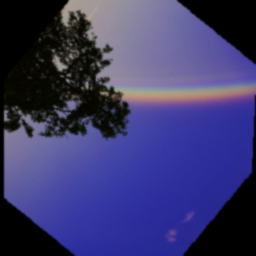

In [64]:
new  = Image.fromarray(np.uint8(data1[6])).convert('RGB')
new

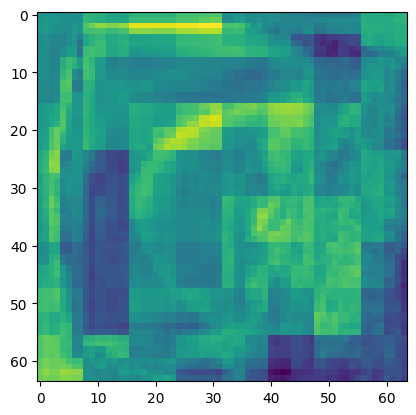

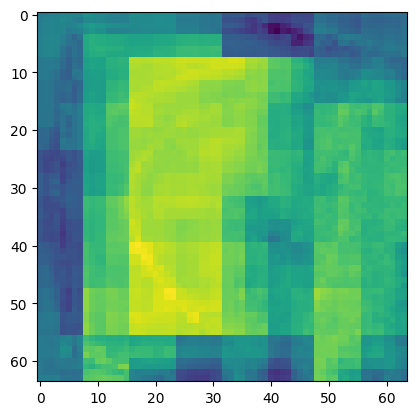

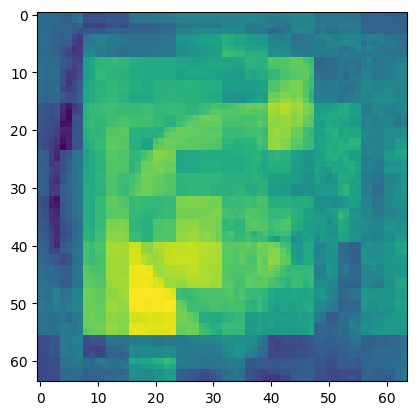

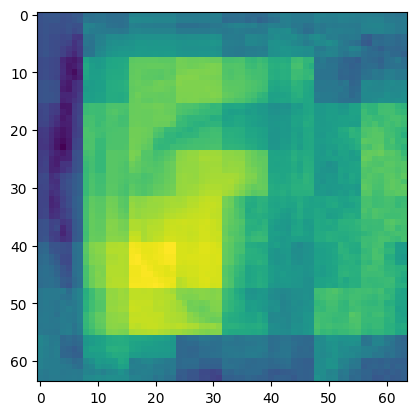

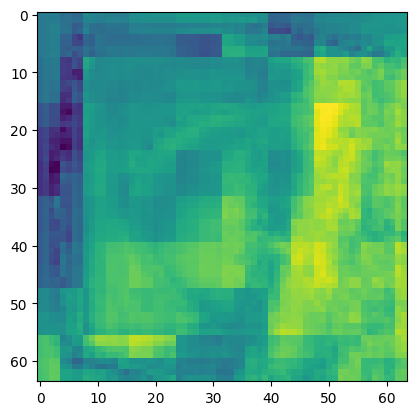

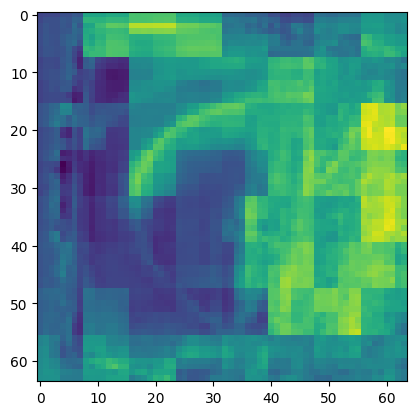

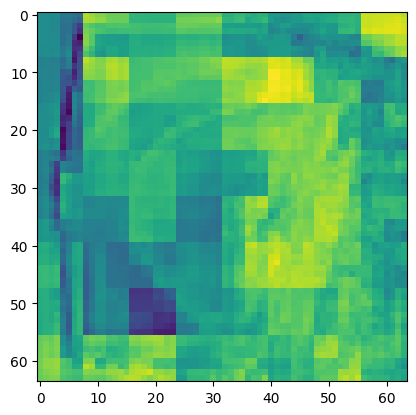

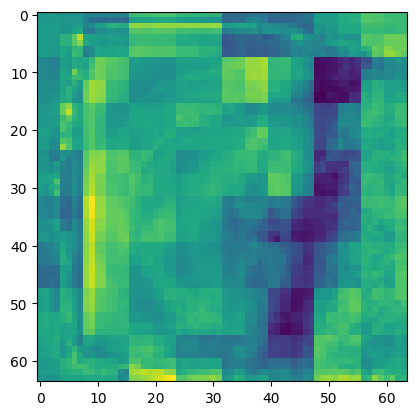

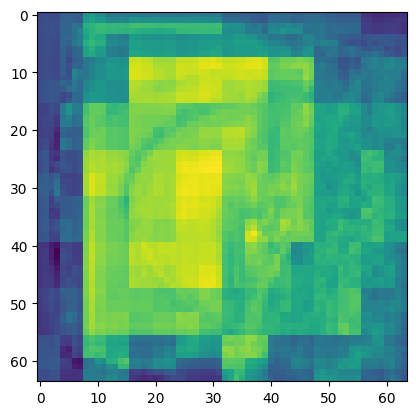

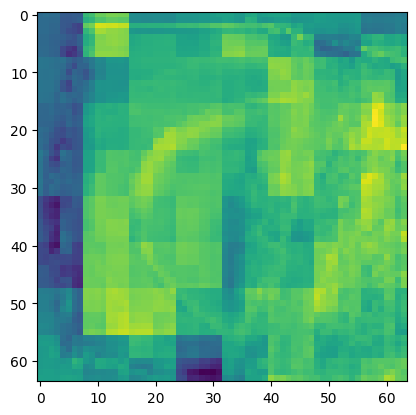

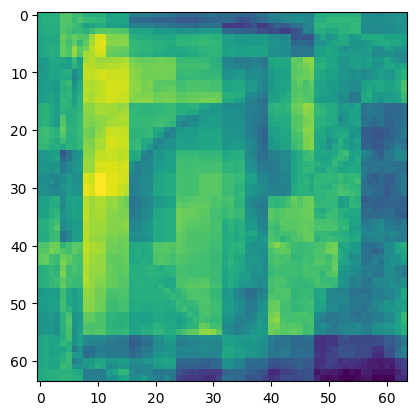

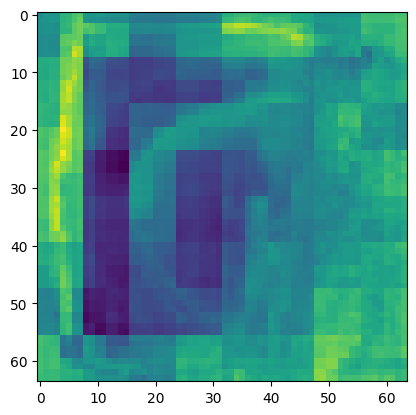

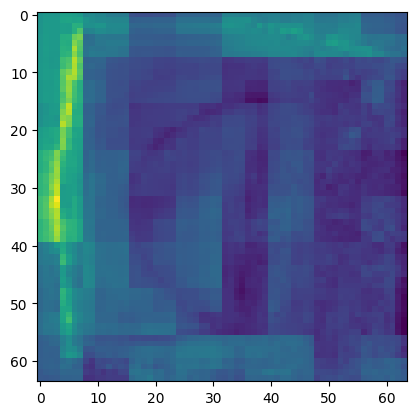

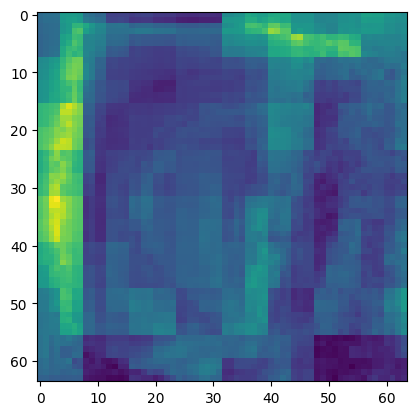

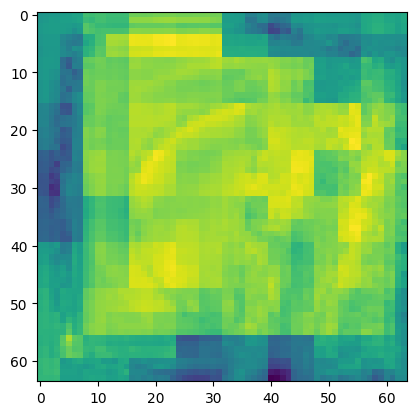

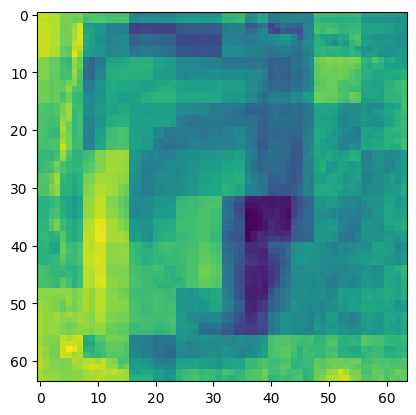

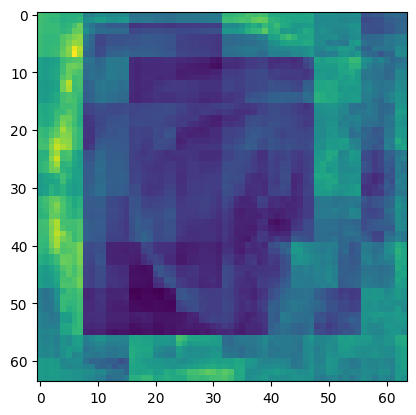

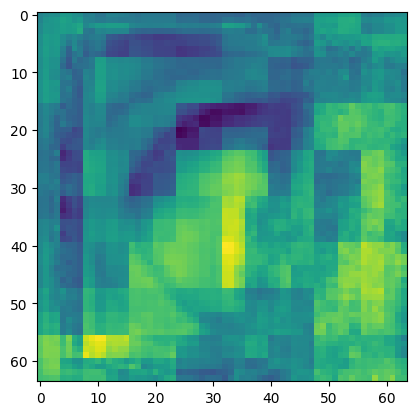

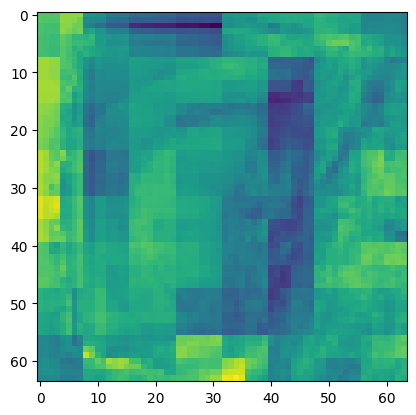

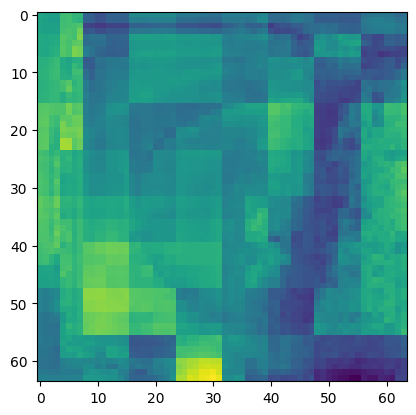

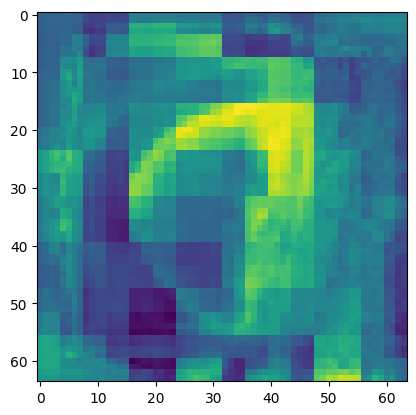

In [142]:
for i in range(len(output)):
    plt.imshow(output[i])
    plt.show()